<a href="https://colab.research.google.com/github/peeyushsinghal/ERA/blob/main/s10/s10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchsummary

In [2]:
from __future__ import print_function
import torch
import torch.optim as optim
from torchvision import datasets, transforms
import os

In [3]:
import albumentations as A
import numpy as np
from albumentations.pytorch.transforms import ToTensorV2

In [4]:
def apply_custom_resnet_transforms(mean,std_dev):
    train_transforms = A.Compose([A.Normalize(mean=mean, std=std_dev, always_apply=True),
                                  A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),  # padding of 4 on each side of 32x32 image
                                  A.RandomCrop(height=32, width=32, always_apply=True),
                                  A.Cutout(num_holes=1,max_h_size=8, max_w_size=8, fill_value=mean, always_apply= True),
                                  ToTensorV2()
                                 ])

    test_transforms = A.Compose([A.Normalize(mean=mean, std=std_dev, always_apply=True),
                                 ToTensorV2(),
                                 ])

    return lambda img: train_transforms(image=np.array(img))["image"], lambda img: test_transforms(image=np.array(img))["image"]

In [5]:
mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
train_transforms, test_transforms = apply_custom_resnet_transforms(mean,std)
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


100%|██████████| 170498071/170498071 [00:03<00:00, 55897752.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


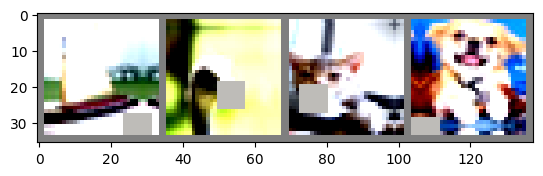

ship  bird  cat   dog  


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [8]:
import torch.nn as nn
import torch.nn.functional as F

dropout_value = 0.1
class ResBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ResBlock,self).__init__()
    self.res_block = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels = out_channels, kernel_size=3, stride =1 , padding =1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels=out_channels, out_channels = out_channels, kernel_size=3, stride =1 , padding =1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

  def forward (self, x):
    x = self.res_block(x)
    return x


class LayerBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(LayerBlock,self).__init__()
    self.layer_block = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels = out_channels, kernel_size=3, stride =1 , padding =1),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

  def forward (self, x):
    x = self.layer_block(x)
    return x

class custom_resnet_s10(nn.Module):
  def __init__(self, num_classes=10):
    super(custom_resnet_s10,self).__init__()

    self.PrepLayer = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels=64, kernel_size = 3, stride = 1, padding =1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
    )
    self.Layer1 = LayerBlock(in_channels = 64, out_channels=128)
    self.resblock1 = ResBlock(in_channels =128, out_channels=128)
    self.Layer2 = LayerBlock(in_channels = 128, out_channels=256)
    self.resblock2 = ResBlock(in_channels =256, out_channels=256)
    self.Layer3 = LayerBlock(in_channels = 256, out_channels=512)
    self.resblock3 = ResBlock(in_channels =512, out_channels=512)
    self.max_pool4 = nn.MaxPool2d(kernel_size=4, stride=4) # 512,512, 4/4 = 512,512,1
    self.fc = nn.Linear(512,num_classes)

  def forward(self,x):
    x = self.PrepLayer(x)
    #################
    x = self.Layer1(x)
    # print("x..l1",x.shape)
    resl1 = self.resblock1(x)
    # print("resl1",resl1.shape)
    x = x+resl1
    # print("x..l1+resl1",x.shape)
    #################
    x = self.Layer2(x)
    # print("x..l2",x.shape)
    resl2 = self.resblock2(x)
    # print("resl2",resl2.shape)
    x = x+resl2
    # print("x..l2+resl2",x.shape)
    #################
    x = self.Layer3(x)
    # print("x..l3",x.shape)
    resl3 = self.resblock3(x)
    # print("resl3",resl3.shape)
    x = x+resl3
    # print("x..l3+resl3",x.shape)
    #################
    x = self.max_pool4(x)
    # print("x..max_pool4",x.shape)
    x = x.view(x.size(0),-1)
    # print("x..flat",x.shape)
    x = self.fc(x)
    return x

In [9]:
Net = custom_resnet_s10()
rand_img = torch.rand(1,3,32,32)
Net(rand_img)

tensor([[ 1.8313, -1.1939,  0.7487, -0.0090,  1.4934, -0.2942,  2.2631,  0.7028,
          1.0375, -1.2412]], grad_fn=<AddmmBackward0>)

In [10]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = custom_resnet_s10().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
        LayerBlock-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,584
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1,

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

### One Cycle LR

In [12]:
import copy
model_oclr = copy.deepcopy(model)
model_oclr = model_oclr.to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_oclr.parameters(), lr=0.01)

In [14]:
! pip install torch_lr_finder


/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.25E+00


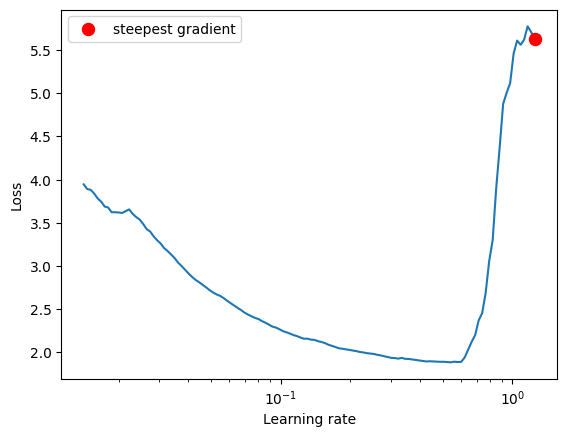

In [15]:
from torch_lr_finder import LRFinder
from tqdm.autonotebook import tqdm

lr_finder = LRFinder(model_oclr, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state